# High order Prince methods `Pr7`, `Pr8` and `Pr9`

[Prince](http://www.peteprince.co.uk/parallel.pdf) has developed some interesting high order methods. These methods are well suited to calculate accurate reference solutions with dense output.

## Main idea

A quick overview of the main idea is presented here; see the [paper](http://www.peteprince.co.uk/parallel.pdf) for all details. The classical way to create a Runge Kutta method is to create a discrete method with optimal properties and a good embedded method for error estimation. The dense output is then appended later. Higher order methods need extra function evaluations to create an interpolant of the same order or one order lower. For example, 'DOP853' needs 3 extra evaluation for a 7th order interpolant. Intuitively it makes sense that it's harder to create an accurate solution over an interval than for one specific point. The higher the order, the more extra evaluations are needed.

The thought behind these methods of Prince is: if we need a high number of evaluations for interpolant order anyway, can't we use all of them to improve the discrete method too? First all conditions for an interpolant of a certain order are met and then the remaining degrees of freedom are used to get low error for the discrete method (and the continuous method). The embedded method is added later. For higher orders, the discrete method can be one order higher than the continuous method (interpolant).

## The methods

Extensisq contains 3 methods from the paper: `Pr7`, `Pr8`, and `Pr9`. The number in the name refers to the order of the discrete method, but the sections of the paper refer to the order of the continuous method, which is one lower. So the method `Pr7` is presented in the paper in section 'Order 6'. The embedded methods are two orders lower than the discrete methods. The stability regions of these methods are:

![Stability region Pr7](stability%20regions/stabilityPr7.png)

![Stability region Pr8](stability%20regions/stabilityPr8.png)

![Stability region Pr9](stability%20regions/stabilityPr9.png)

I didn't include the 10th order method in Extensisq. It wasn't much better than the 9th order method in the tests that I ran. This is probably because of rounding errors in my numerically naive implementation. (The paper recommends high precision arithmetic for the higher order methods.)

## Test problem

The methods are demonstrated on problem A2 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set: a special case of the Riccati equation. The initial value problem is:

In [1]:
problem = {'fun' : lambda x, y: -y**3/2,
            'y0' : [1.],
        't_span' : [0., 20.]}

## Reference solution

This problem has an analytic solution that will be used as reference:

In [2]:
reference = lambda x: (x+1)**-0.5

## Solution plot

The plot below shows the solution. It appears to be a simple, smooth curve.

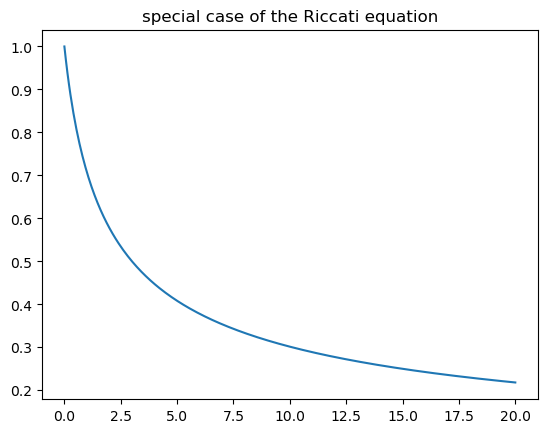

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

t = np.linspace(*problem['t_span'], 300)

plt.figure()
plt.plot(t, reference(t))
plt.title('special case of the Riccati equation')
plt.show()

## Efficiency plot

The efficiency of the methods can be assessed by making a plot of the error versus the number of derivative function evaluations. The error is calculated by the RMS norm, defined for the discrete solution (t=None) and a continuous solution:

In [4]:
def rms_err_norm(solution, reference, t=None):
    if t is None:
        error = solution.y - reference(solution.t)
    else:
        error = solution.sol(t) - reference(t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Let's solve this problem with `Pr7`, `Pr8` and `Pr9` at several absolute tolerance values and make a plot to show the efficiency of these methods. The scipy methods `RK45` and `DOP853` (with coefficients by Dormand and *Prince*) are included for comparison.

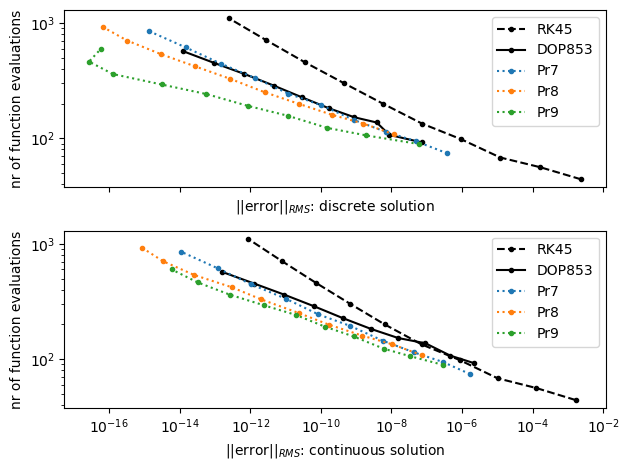

In [5]:
from scipy.integrate import solve_ivp
from extensisq import Pr7, Pr8, Pr9

methods = ['RK45', 'DOP853', Pr7, Pr8, Pr9]
tolerances = np.logspace(-3, -12, 10)

fig, axs = plt.subplots(2, sharex=True)
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e_disc = []
    e_cont = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=tol, atol=tol, method=method,
                        dense_output=True) # this triggers extra evaluations in DOP853
        e_disc.append(rms_err_norm(sol, reference))
        e_cont.append(rms_err_norm(sol, reference, t))
        n.append(sol.nfev)
    if name == 'RK45':
        style = '--k.'
    elif name == 'DOP853':
        style = '-k.'
    else:
        style = '.:'
    axs[0].loglog(e_disc, n, style, label=name)
    axs[1].loglog(e_cont, n, style, label=name)
axs[0].set_xlabel(r'||error||$_{RMS}$: discrete solution')
axs[1].set_xlabel(r'||error||$_{RMS}$: continuous solution')
for ax in axs:
    ax.set_ylabel('nr of function evaluations')
    ax.legend()
plt.tight_layout()
plt.show()    

The Riccati equation is solved efficiently by the new methods of Prince. The discrete efficiency graph (upper graph) shows:

* `Pr9` is the most efficient method.
* 'DOP853' performs in-between `Pr7` and `Pr8`. This speaks to the efficiency of both new methods, because the orders of 'DOP853' are similar to those of `Pr8` (7th order continuous method (interpolant) and 8th order discrete method).
* Dense output was requested. This triggers extra evaluations in `DOP853`. Without dense output, `DOP853` and `Pr8` have a similar efficiency at tight tolerance for this problem. This means that the extra evaluations in `Pr8` improve the accuracy proportionally and that the dense output comes essentially for free, for this problem at least. (The methods of Prince don't require extra evaluations for dense output.)
* The results are relatively accurate compared to the tolerance. This is probably because the embedded method is two orders lower than the discrete method.
* The error of `Pr9` is limited to near 1e-16. Rounding errors start to dominate here and tighter tolerances lead to more function evaluations but not to lower errors anymore.
* `RK45` works well at modest tolerances, but is inefficient at lower tolerances.

The lower graph shows the error in the continuous solution. Some remarks:

* The continuous errors of all methods (including 'DOP853') are higher than the discrete errors.
* `Pr7` has a lower continuous error than 'DOP853' almost everywhere, despite having a lower order interpolant.
* `Pr8` sees the least deterioration (besides 'RK45').
* The continuous error of `Pr9` is close to the continuous error of `Pr8`.

## Conclusion

* `Pr7` has a nice stability region for imaginary poles.
* `Pr8` has an accurate dense output that comes for free compared to `DOP853`.
* `Pr9` calculates an accurate discrete solution efficiently.
* (The last two conclusions may be different for another problem though.)

I think that these methods by Prince are a useful addition to the default scipy methods for many problems that need to be solved with high accuracy and a dense_output.